# Crypto algo trading using RL models

## Data preparation

In [1]:
from utils import get_ready_dataframe, split_dataframe, normalize_column

df = get_ready_dataframe('BTC', '1d')
df, scaler = normalize_column(df, 'close', 'MinMax')

In [2]:
train_ratio = 0.8
train_df, test_df = split_dataframe(df, train_ratio)

In [3]:
train_df.tail()

,close
timestamp,
2019-11-11 23:59:59,0.136980
2019-11-12 23:59:59,0.137893
2019-11-13 23:59:59,0.137776
2019-11-14 23:59:59,0.136197
2019-11-15 23:59:59,0.132790


In [4]:
test_df.head()

,close
timestamp,
2019-11-16 23:59:59,0.133717
2019-11-17 23:59:59,0.134146
2019-11-18 23:59:59,0.129910
2019-11-19 23:59:59,0.128284
2019-11-20 23:59:59,0.125464


## Environment preparation

In [5]:
import gym
import gym_anytrading
from environment import CryptoStockEnv

window_size = 50            # amount of previous data to be used for prediction
start_index = window_size
train_end_index = len(train_df)
test_end_index = len(test_df)

train_env = CryptoStockEnv(df=train_df, window_size=window_size, frame_bound=(start_index, train_end_index), scaler=scaler, initial_balance=100)
test_env = CryptoStockEnv(df=test_df, window_size=window_size, frame_bound=(start_index, test_end_index), scaler=scaler, initial_balance=100)

In [6]:
train_env.signal_features   # inputs

array([[ 1.19979445e-03,  0.00000000e+00],
       [ 1.11246111e-03, -8.73333481e-05],
       [ 7.65491881e-04, -3.46969225e-04],
       ...,
       [ 1.37776115e-01, -1.16654115e-04],
       [ 1.36197059e-01, -1.57905643e-03],
       [ 1.32790375e-01, -3.40668387e-03]])

In [7]:
train_env.prices            # labels

array([0.00119979, 0.00111246, 0.00076549, ..., 0.13777612, 0.13619706,
       0.13279037])

## Models

### DQN

In [8]:
from stable_baselines3 import DQN

dqn_model = DQN.load('models/DQN.zip')
# dqn_model = DQN('MlpPolicy', train_env, verbose=True, buffer_size=100_000)
# dqn_model.learn(total_timesteps=500_000)
# dqn_model.save('DQN')

### PPO

In [9]:
from stable_baselines3 import PPO

ppo_model = PPO.load('models/PPO.zip')
# ppo_model = PPO('MlpPolicy', train_env, verbose=True)
# ppo_model.learn(total_timesteps=100_000)
# ppo_model.save('PPO')

### PPO LSTM

In [10]:
from sb3_contrib import RecurrentPPO

ppo_lstm_model = RecurrentPPO.load('models/PPO_LSTM.zip')
# ppo_lstm_model = RecurrentPPO('MlpLstmPolicy', train_env, verbose=True)
# ppo_lstm_model.learn(total_timesteps=50_000)
# ppo_lstm_model.save('PPO_LSTM')

## Visualizing models

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_trading(model):
    observation = test_env.reset()

    while True:
        observation = observation[np.newaxis, ...]

        if model == 'random':
            action = test_env.action_space.sample()
        else:
            action, _states = model.predict(observation)
        observation, reward, done, info = test_env.step(action)

        # env.render()
        if done:
            print("info:", info)
            break
    print("Max_possible_profit:", test_env.max_possible_profit())

    plt.figure(figsize=(16, 6))
    test_env.render_all()
    plt.show()

In [28]:
import quantstats as qs
import pandas as pd

qs.extend_pandas()

def evaluate_results(model: str = '', save=False):
    start_index, end_index = test_env.frame_bound
    net_worth = pd.Series(test_env.history['total_profit'], index=test_env.df.index[start_index+1:end_index])
    returns = net_worth.pct_change().iloc[1:]

    qs.reports.full(returns)
    if save:
        qs.reports.html(returns, output=True, download_filename=f'reports/{model} Results.html', )

### Random trading

info: {'total_reward': -0.6107517912399953, 'total_profit': 21.639430277111796, 'position': 1}
Max_possible_profit: 2476840.9002343095


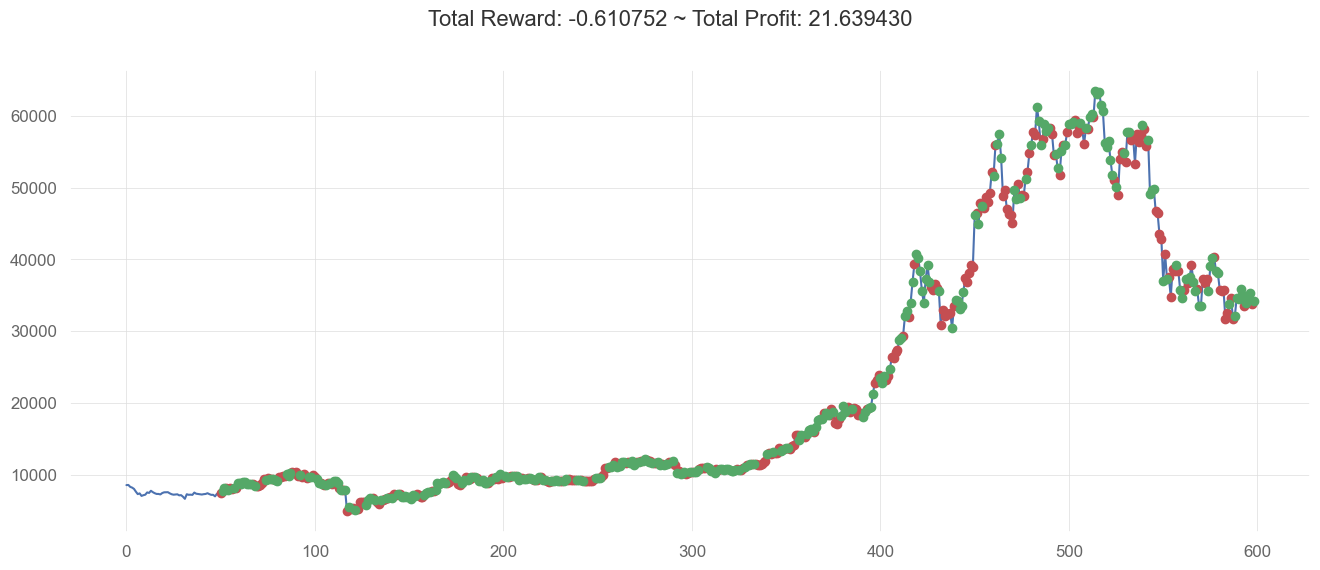

In [13]:
visualize_trading(model='random')

                           Strategy
-------------------------  ----------
Start Period               2020-01-07
End Period                 2021-07-06
Risk-Free Rate             0.0%
Time in Market             11.0%

Cumulative Return          -91.41%
CAGR﹪                     -80.62%

Sharpe                     -1.64
Prob. Sharpe Ratio         0.04%
Smart Sharpe               -1.58
Sortino                    -1.73
Smart Sortino              -1.67
Sortino/√2                 -1.23
Smart Sortino/√2           -1.18
Omega                      0.34

Max Drawdown               -91.41%
Longest DD Days            531
Volatility (ann.)          57.06%
Calmar                     -0.88
Skew                       -6.04
Kurtosis                   51.96

Expected Daily %           -0.45%
Expected Monthly %         -12.12%
Expected Yearly %          -70.69%
Kelly Criterion            -83.17%
Risk of Ruin               0.0%
Daily Value-at-Risk        -6.28%
Expected Shortfall (cVaR)  -6.28%

Max Consec

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-01-22,2021-07-06,2021-07-06,531,-91.410782,-87.33721


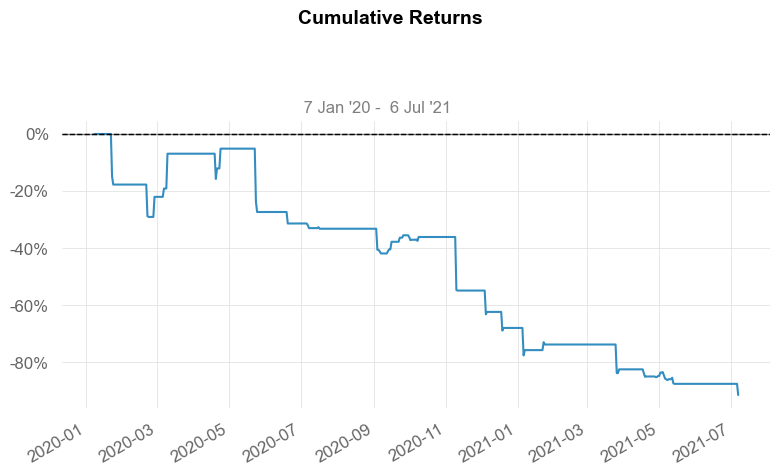

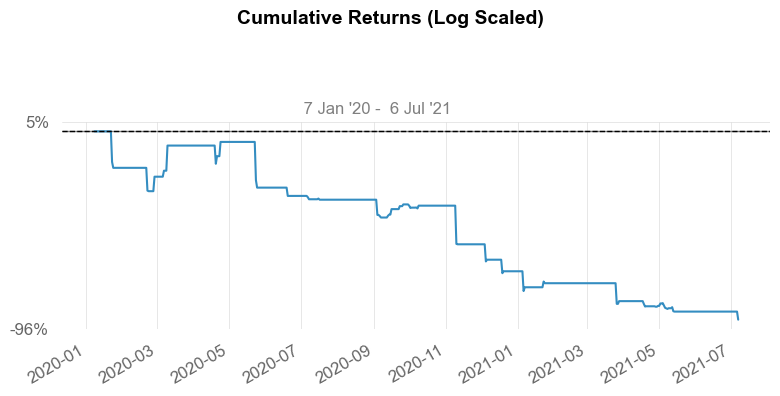

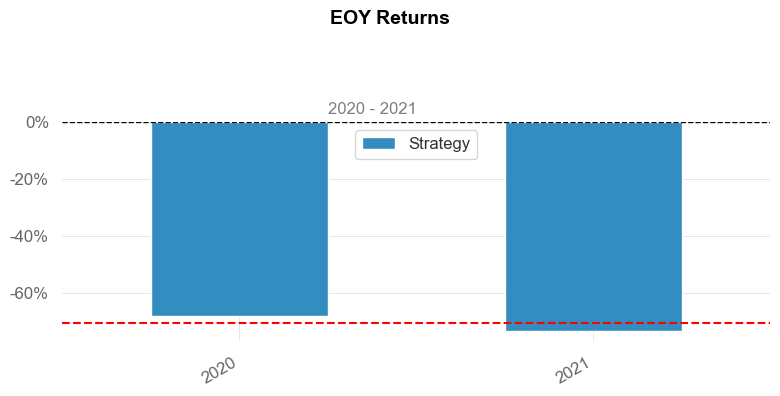

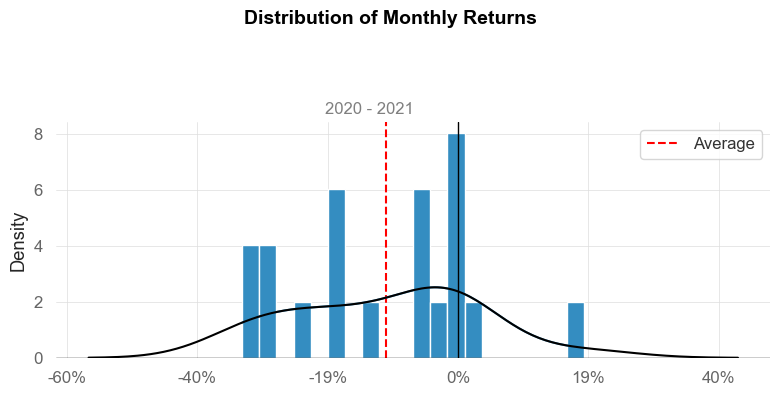

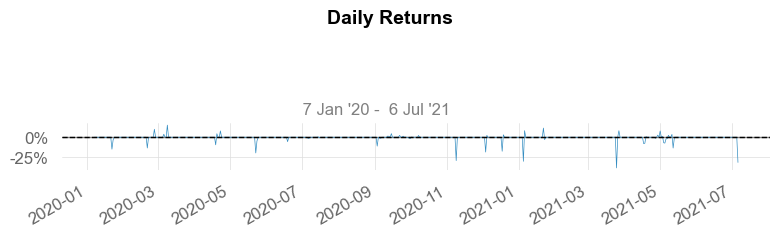

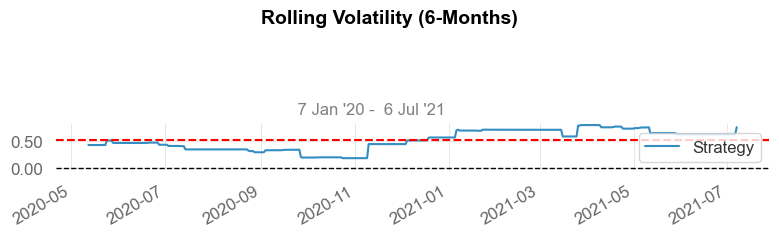

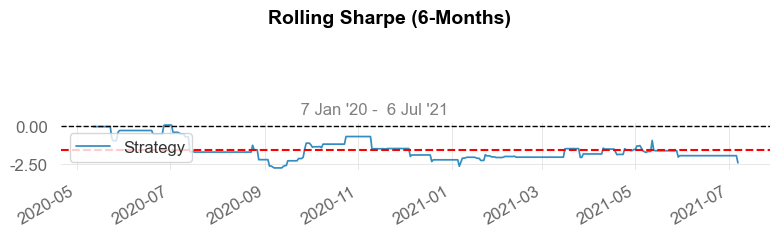

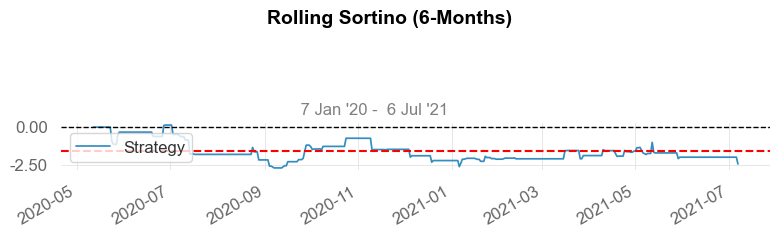

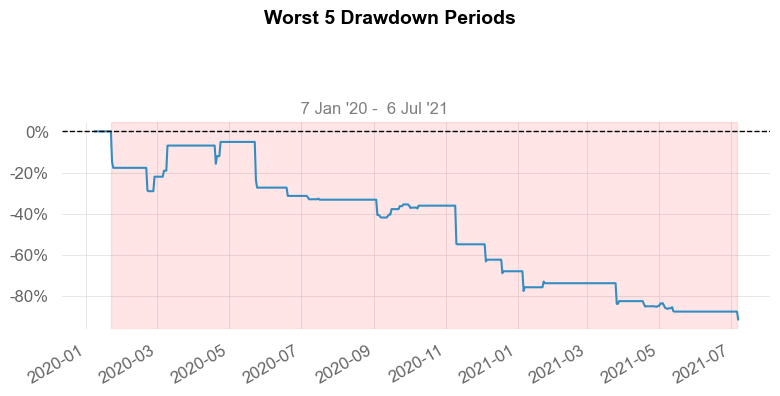

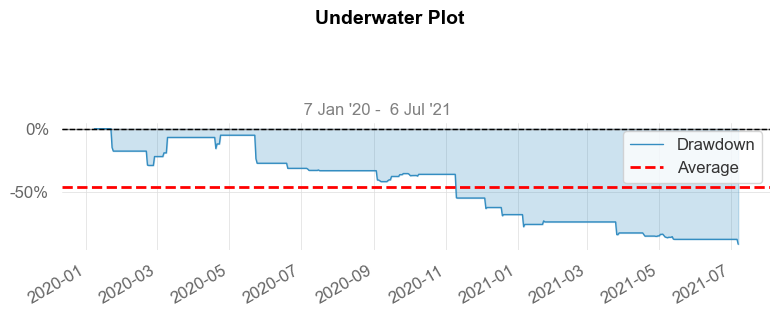

D:\Vanya\Projects\Python\Neural Networks\venv\Lib\site-packages\quantstats\stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


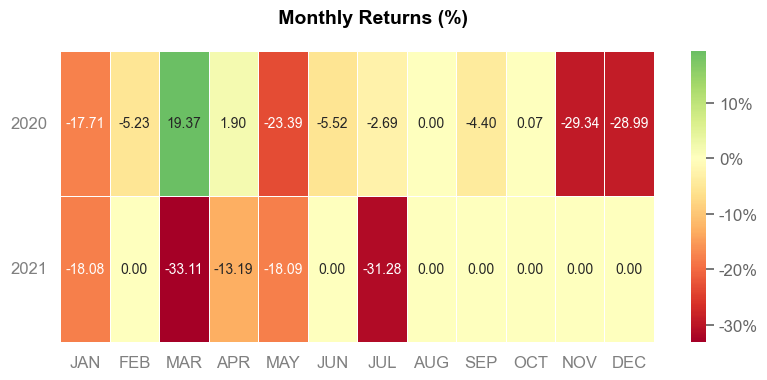

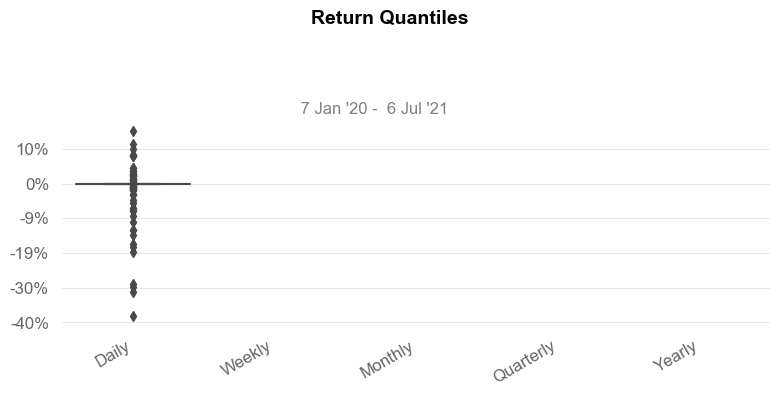

D:\Vanya\Projects\Python\Neural Networks\venv\Lib\site-packages\quantstats\stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


In [29]:
evaluate_results(model='Random', save=True)

### DQN trading

info: {'total_reward': -0.9804744023007601, 'total_profit': 21.352952388196538, 'position': 1}
Max_possible_profit: 2476840.9002343095


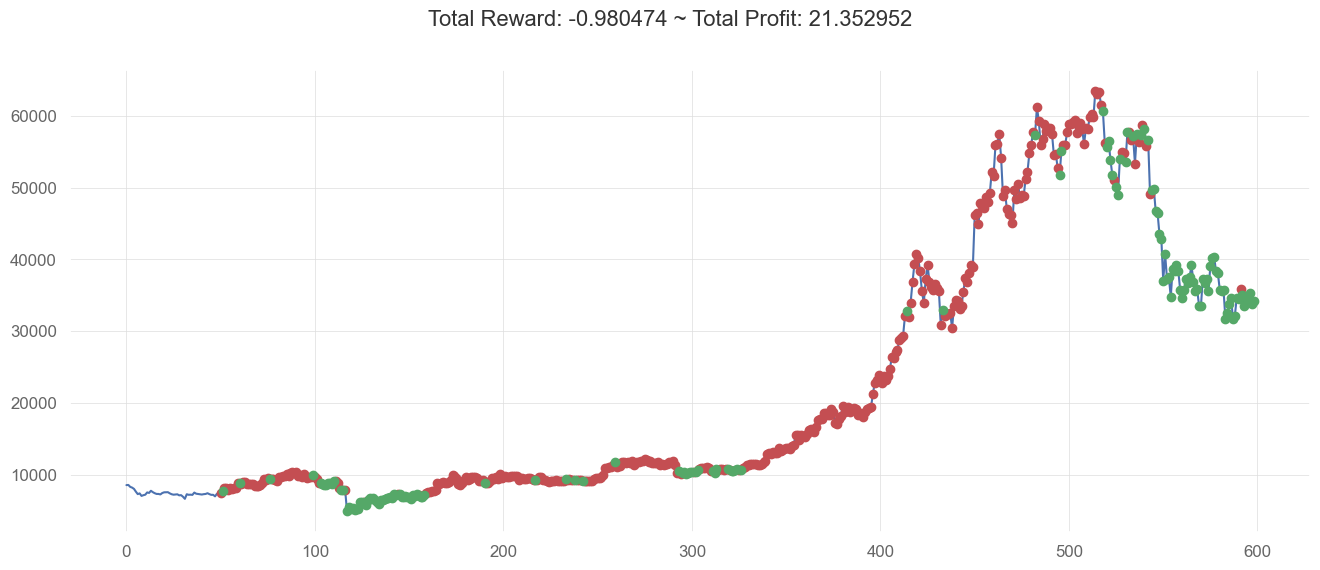

In [57]:
visualize_trading(dqn_model)

                           Strategy
-------------------------  ----------
Start Period               2020-01-07
End Period                 2021-07-06
Risk-Free Rate             0.0%
Time in Market             14.0%

Cumulative Return          -77.57%
CAGR﹪                     -63.19%

Sharpe                     -0.31
Prob. Sharpe Ratio         32.4%
Smart Sharpe               -0.3
Sortino                    -0.4
Smart Sortino              -0.39
Sortino/√2                 -0.28
Smart Sortino/√2           -0.28
Omega                      0.82

Max Drawdown               -92.92%
Longest DD Days            408
Volatility (ann.)          82.48%
Calmar                     -0.68
Skew                       -2.17
Kurtosis                   94.87

Expected Daily %           -0.27%
Expected Monthly %         -7.57%
Expected Yearly %          -52.64%
Kelly Criterion            -10.69%
Risk of Ruin               0.0%
Daily Value-at-Risk        -8.65%
Expected Shortfall (cVaR)  -8.65%

Max Consecuti

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-05-24,2021-07-06,2021-07-06,408,-92.916796,-90.133081
2,2020-01-15,2020-02-24,2020-03-09,54,-21.657395,-19.293303
3,2020-04-19,2020-04-19,2020-04-20,1,-1.705121,0.000000
4,2020-03-11,2020-03-11,2020-03-12,1,-0.305213,0.000000


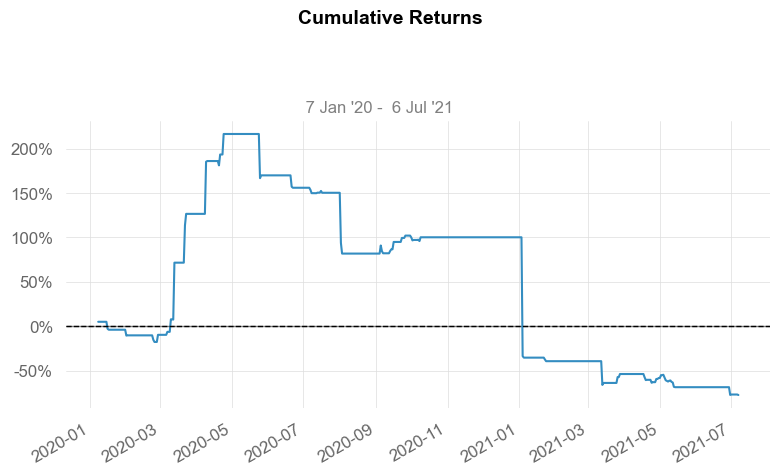

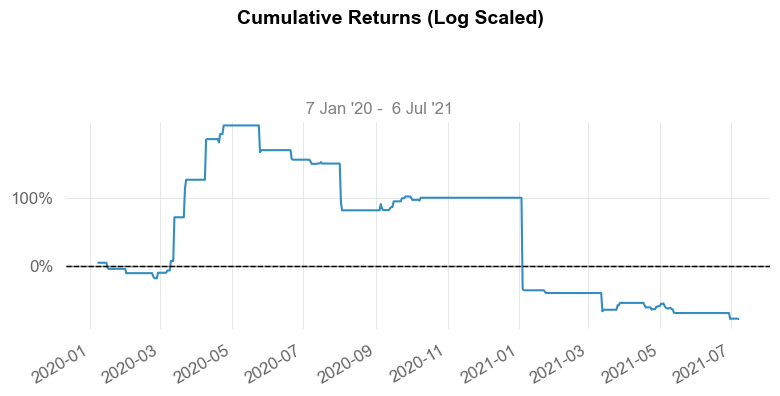

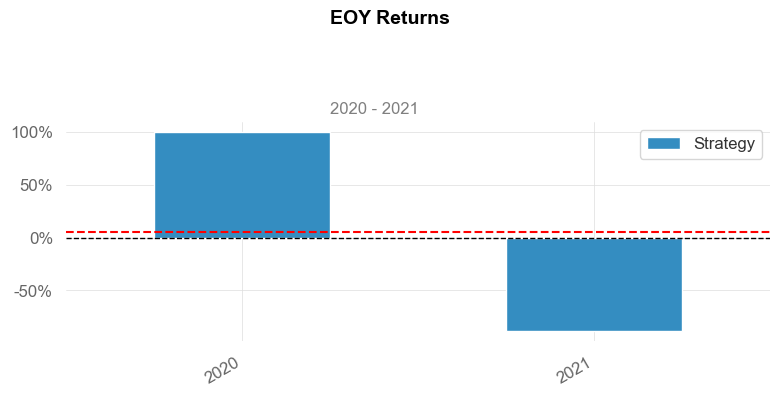

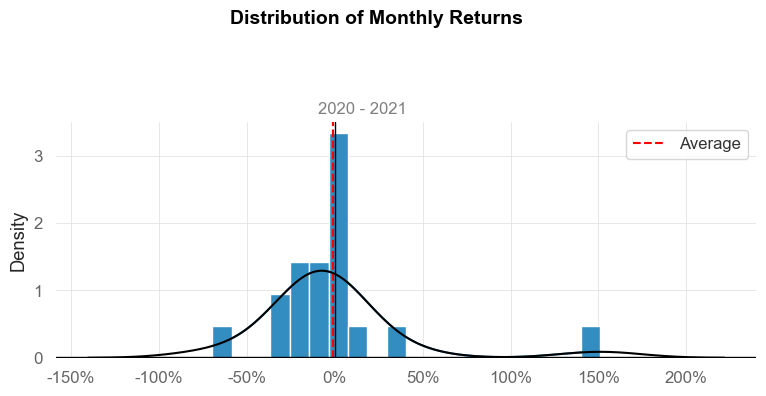

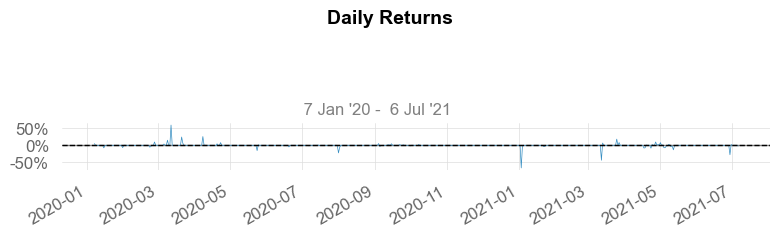

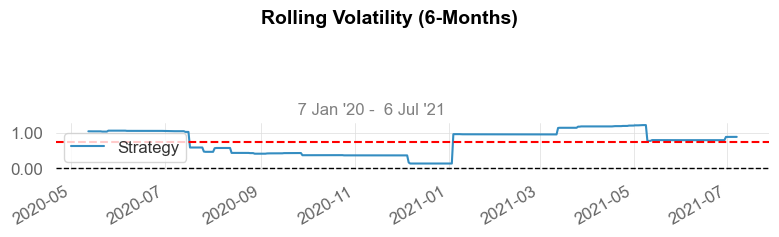

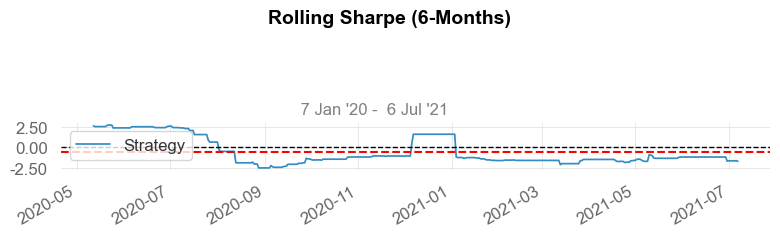

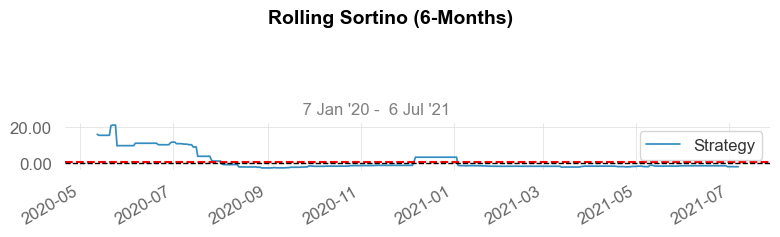

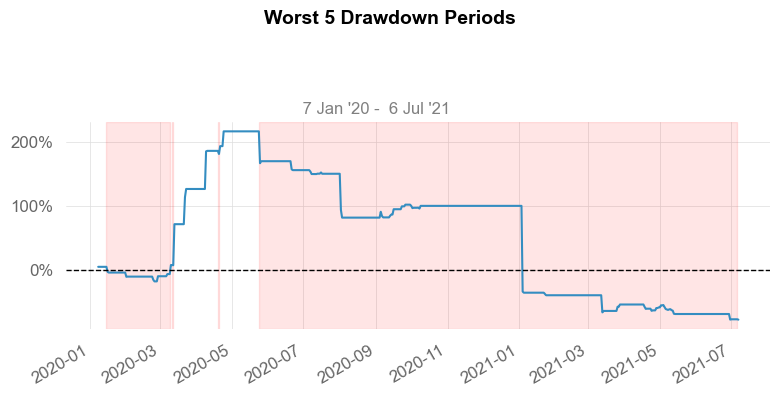

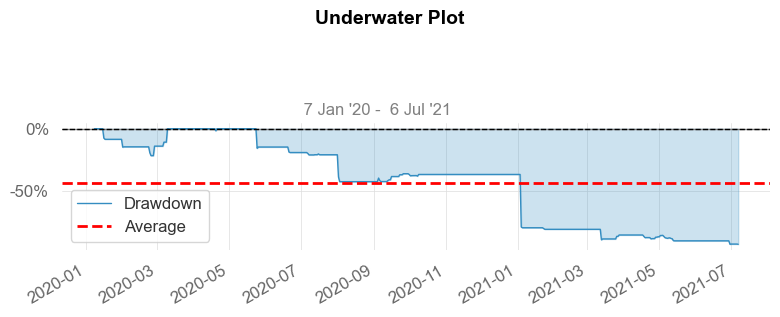

D:\Vanya\Projects\Python\Neural Networks\venv\Lib\site-packages\quantstats\stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


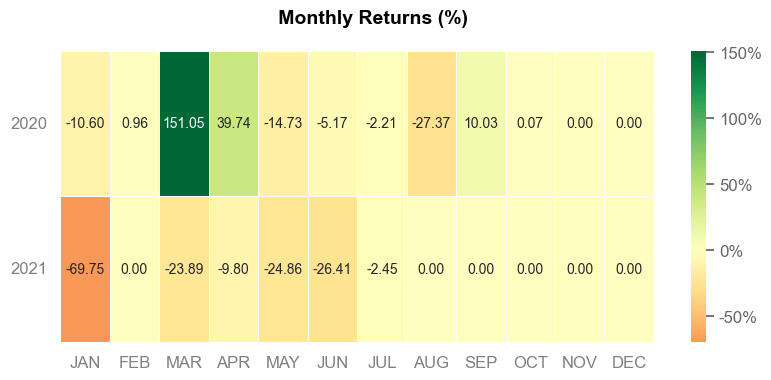

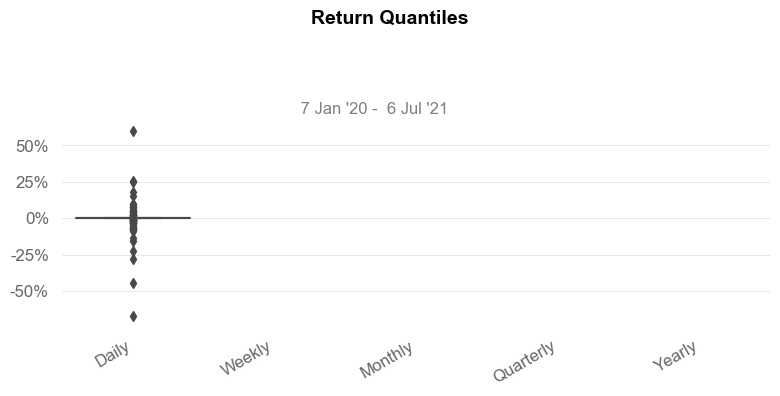

D:\Vanya\Projects\Python\Neural Networks\venv\Lib\site-packages\quantstats\stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


In [58]:
evaluate_results(model='DQN', save=True)

### PPO trading

info: {'total_reward': -0.5432151636763585, 'total_profit': 61.96244791380611, 'position': 0}
Max_possible_profit: 2476840.9002343095


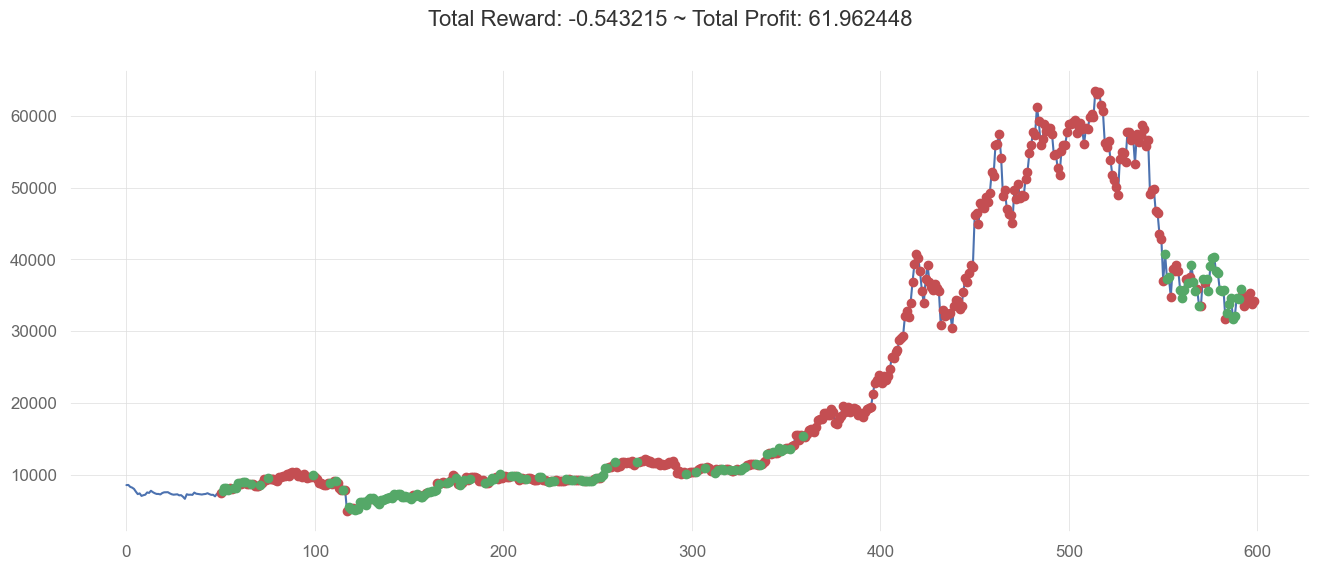

In [67]:
visualize_trading(ppo_model)

                           Strategy
-------------------------  ----------
Start Period               2020-01-07
End Period                 2021-07-06
Risk-Free Rate             0.0%
Time in Market             24.0%

Cumulative Return          -34.91%
CAGR﹪                     -24.96%

Sharpe                     0.14
Prob. Sharpe Ratio         58.02%
Smart Sharpe               0.14
Sortino                    0.19
Smart Sortino              0.19
Sortino/√2                 0.14
Smart Sortino/√2           0.13
Omega                      1.07

Max Drawdown               -83.14%
Longest DD Days            264
Volatility (ann.)          68.2%
Calmar                     -0.3
Skew                       -2.94
Kurtosis                   107.78

Expected Daily %           -0.08%
Expected Monthly %         -2.23%
Expected Yearly %          -19.32%
Kelly Criterion            3.13%
Risk of Ruin               0.0%
Daily Value-at-Risk        -7.03%
Expected Shortfall (cVaR)  -7.03%

Max Consecutive Win

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-10-15,2021-06-22,2021-07-06,264,-83.136719,-82.668470
2,2020-06-01,2020-08-14,2020-10-10,131,-29.822109,-29.625013
3,2020-01-17,2020-02-24,2020-03-13,56,-17.413315,-15.795521
4,2020-05-09,2020-05-13,2020-05-24,15,-13.475316,-12.169084
5,2020-03-15,2020-03-15,2020-03-16,1,-3.264171,0.000000


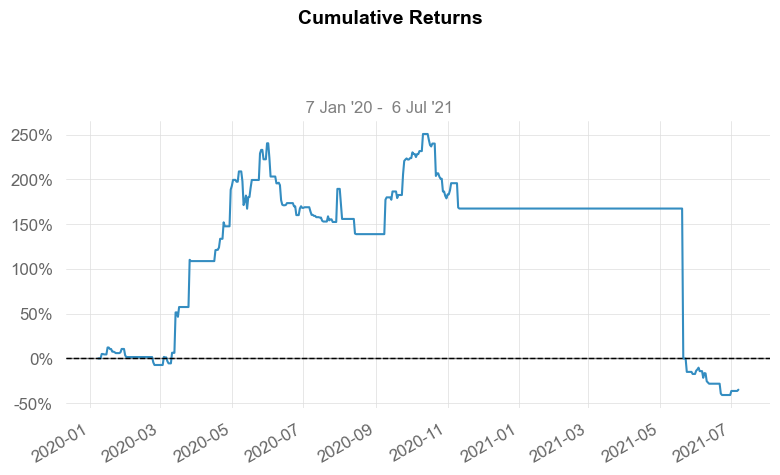

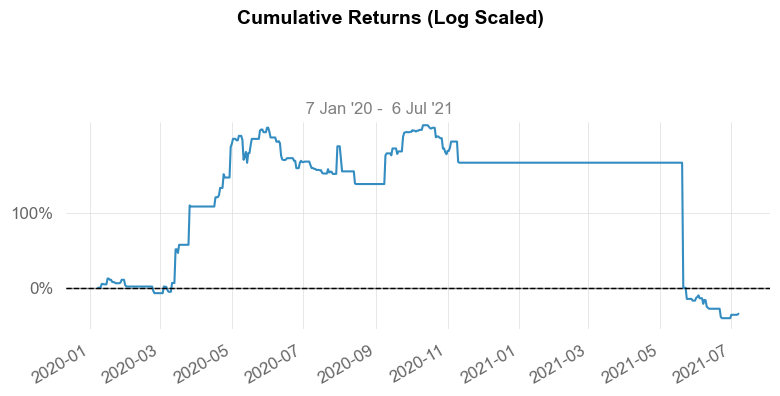

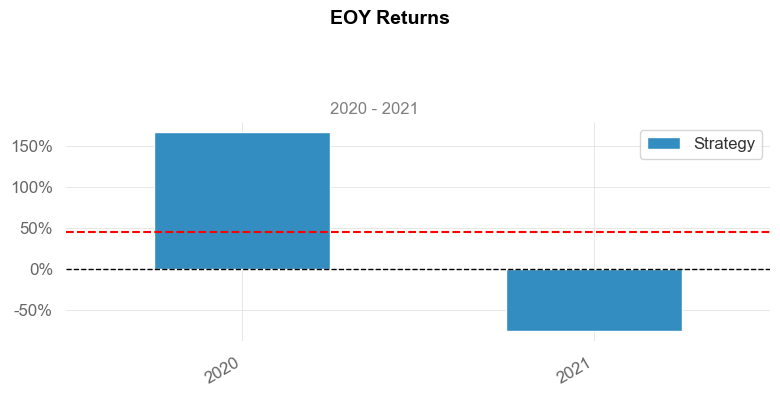

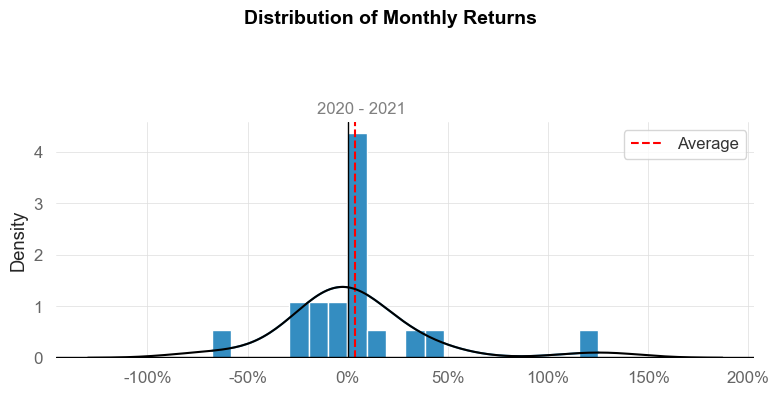

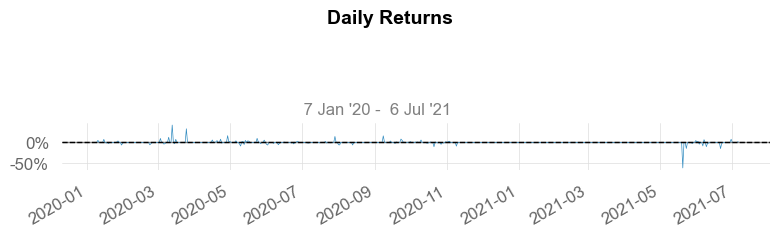

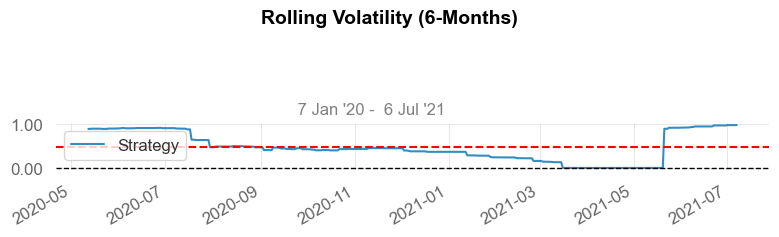

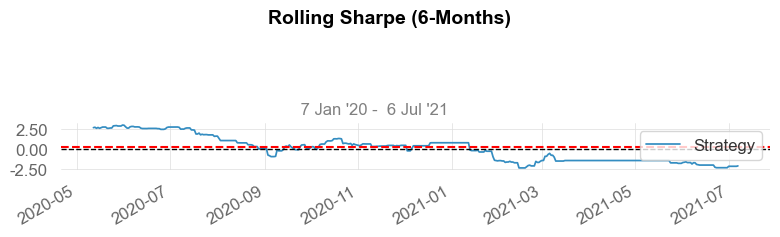

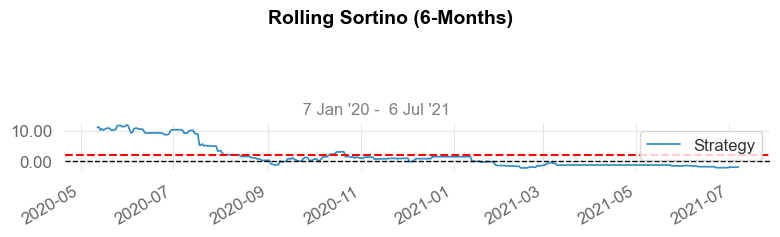

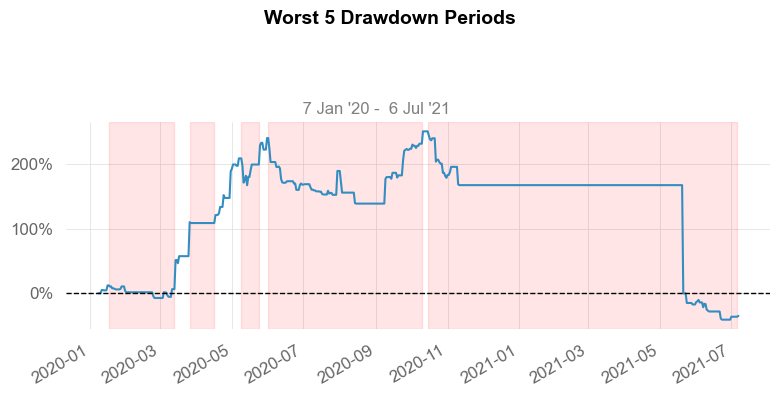

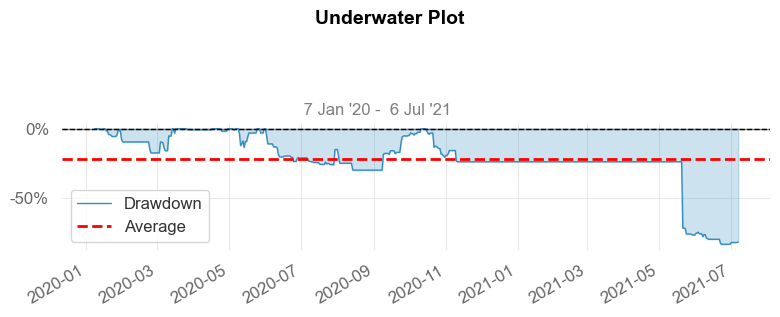

D:\Vanya\Projects\Python\Neural Networks\venv\Lib\site-packages\quantstats\stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


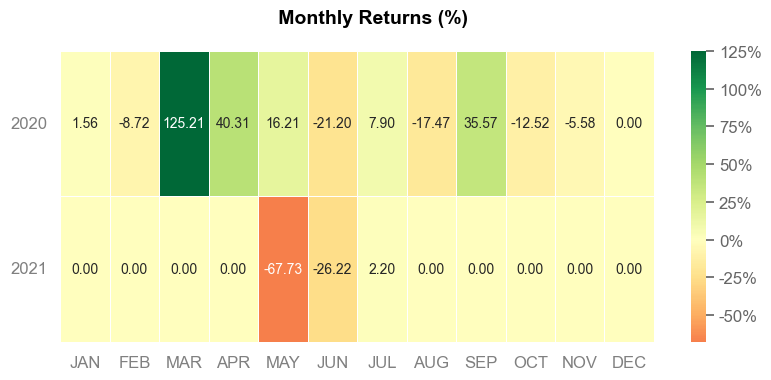

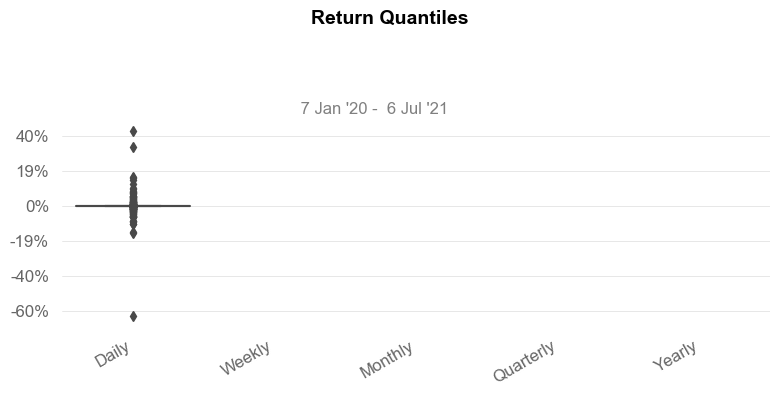

D:\Vanya\Projects\Python\Neural Networks\venv\Lib\site-packages\quantstats\stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


In [68]:
evaluate_results(model='PPO', save=True)

### PPO LSTM trading

info: {'total_reward': -0.005639345873885926, 'total_profit': 77.11819057847167, 'position': 0}
Max_possible_profit: 2476840.9002343095


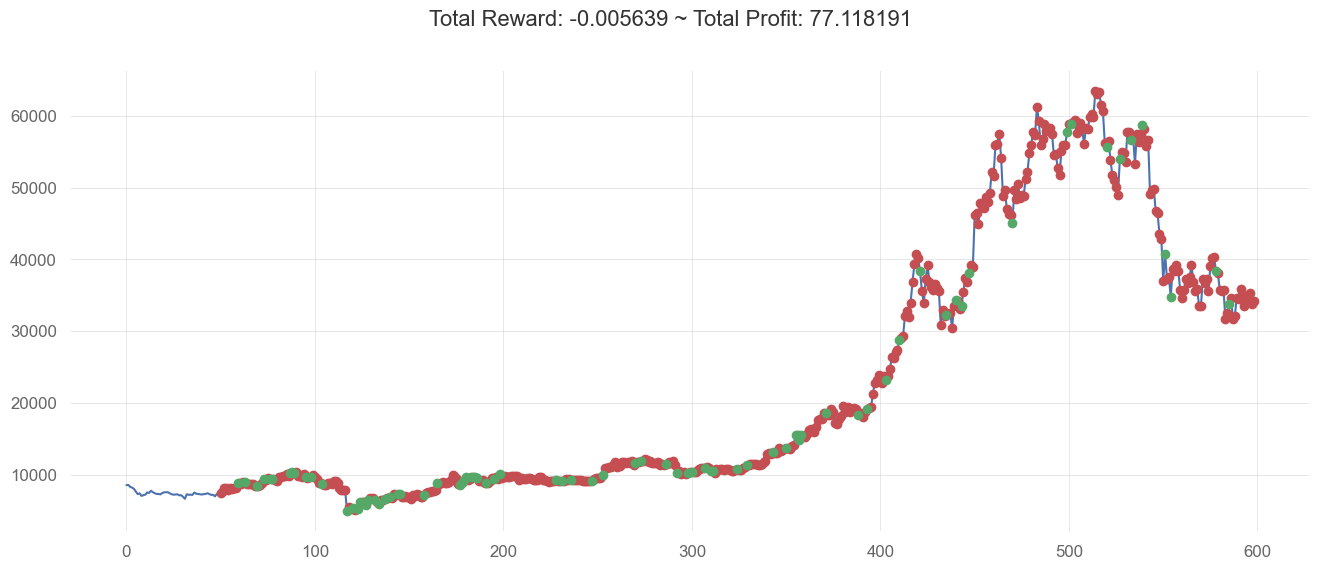

In [79]:
visualize_trading(ppo_lstm_model)

                           Strategy
-------------------------  ----------
Start Period               2020-01-07
End Period                 2021-07-06
Risk-Free Rate             0.0%
Time in Market             25.0%

Cumulative Return          -22.88%
CAGR﹪                     -15.94%

Sharpe                     0.18
Prob. Sharpe Ratio         61.13%
Smart Sharpe               0.18
Sortino                    0.35
Smart Sortino              0.33
Sortino/√2                 0.25
Smart Sortino/√2           0.23
Omega                      1.09

Max Drawdown               -83.63%
Longest DD Days            461
Volatility (ann.)          78.49%
Calmar                     -0.19
Skew                       6.8
Kurtosis                   102.7

Expected Daily %           -0.05%
Expected Monthly %         -1.36%
Expected Yearly %          -12.18%
Kelly Criterion            3.92%
Risk of Ruin               0.0%
Daily Value-at-Risk        -8.08%
Expected Shortfall (cVaR)  -8.08%

Max Consecutive Wins

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-04-01,2021-03-29,2021-07-06,461,-83.631725,-83.325468
2,2020-01-14,2020-02-11,2020-03-12,58,-34.760682,-34.191150
3,2020-03-16,2020-03-18,2020-03-20,4,-11.387774,-7.236287
4,2020-03-28,2020-03-28,2020-03-29,1,-3.700176,0.000000


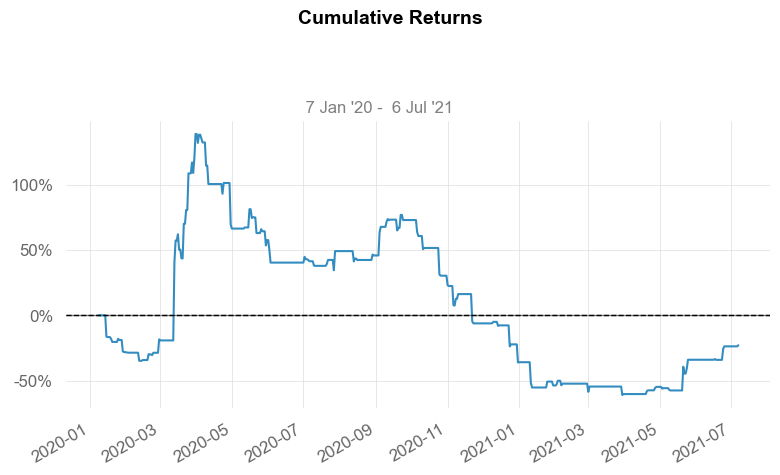

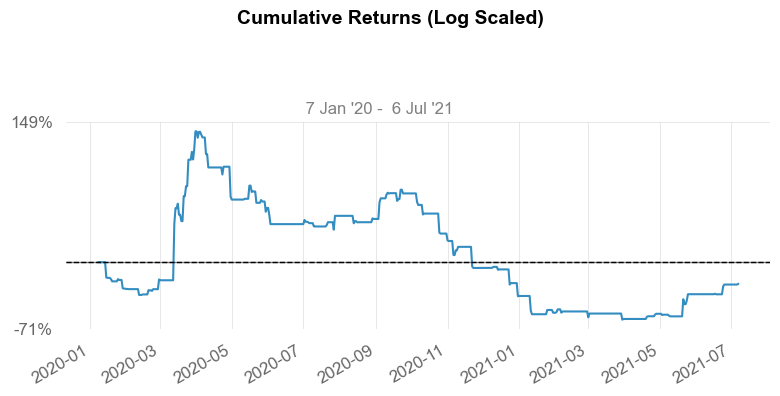

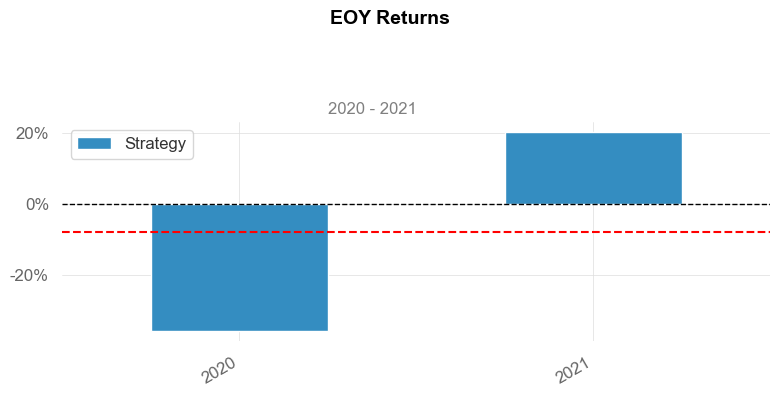

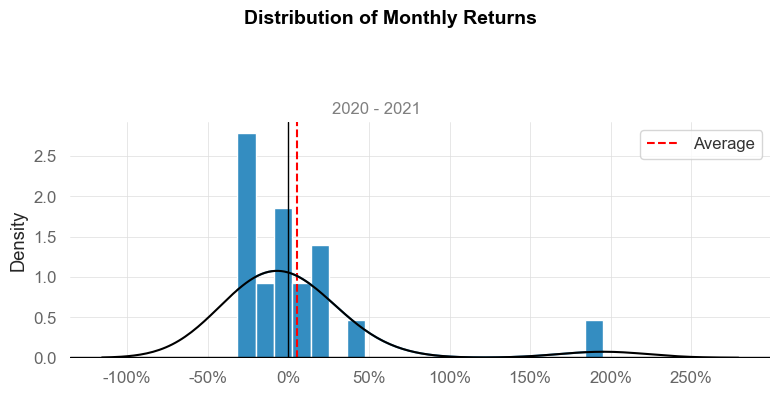

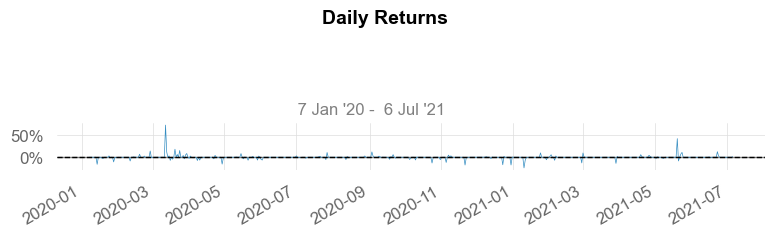

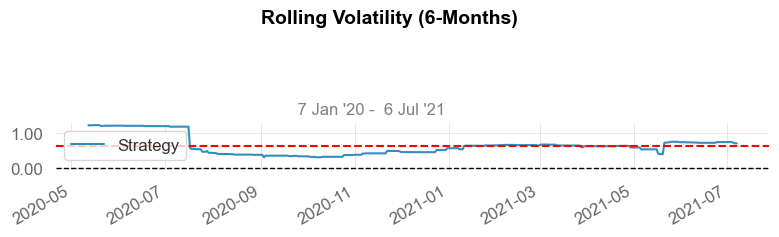

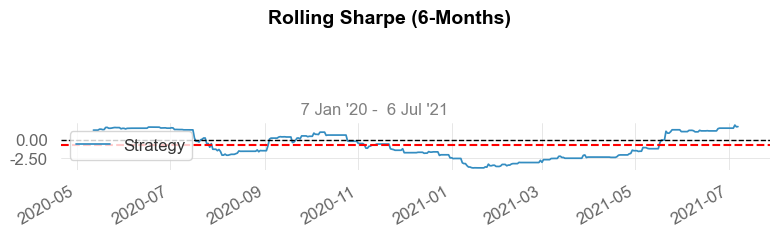

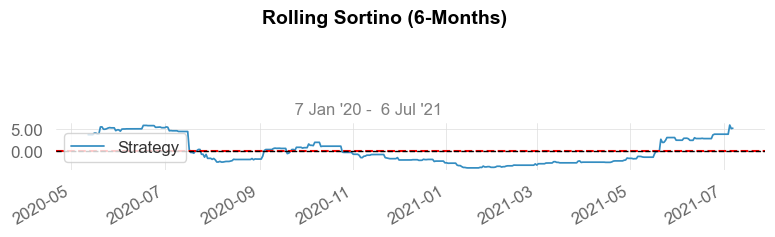

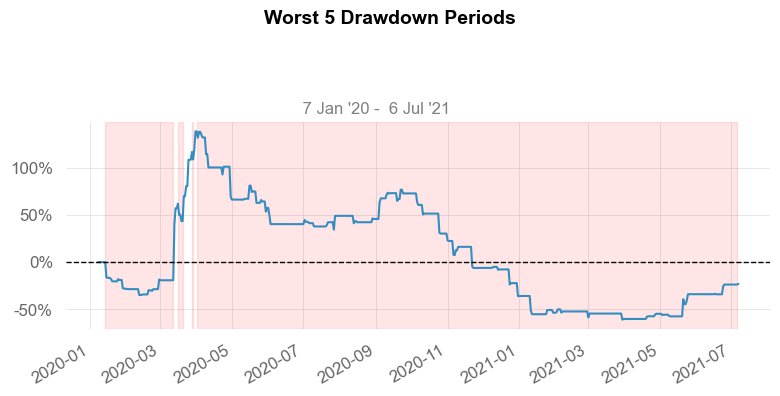

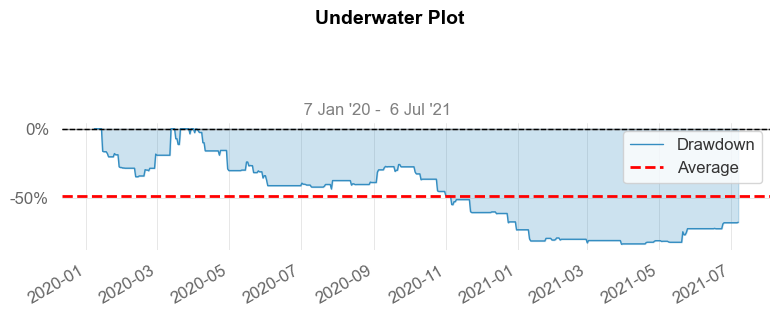

D:\Vanya\Projects\Python\Neural Networks\venv\Lib\site-packages\quantstats\stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


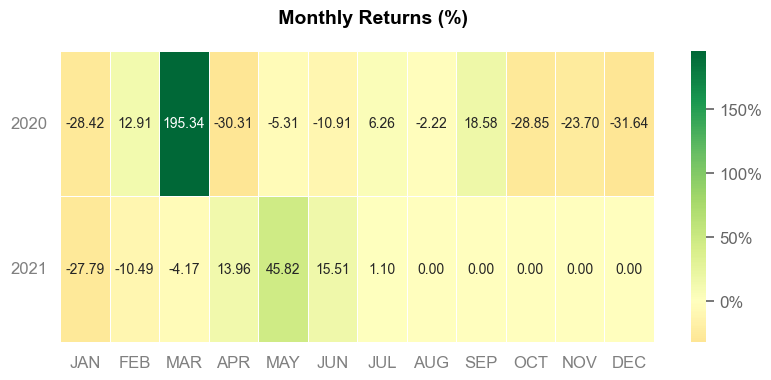

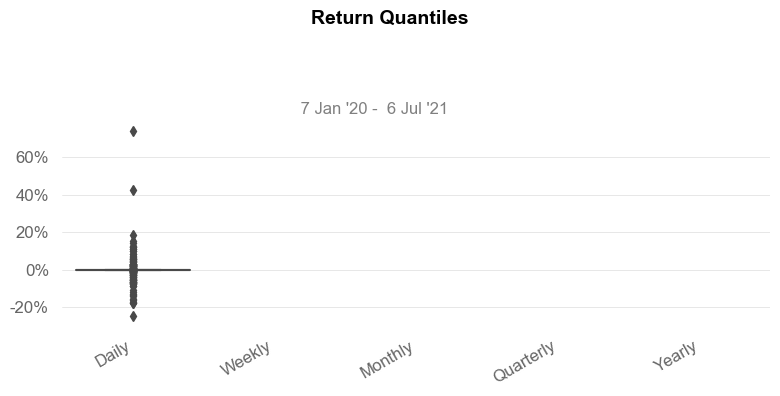

D:\Vanya\Projects\Python\Neural Networks\venv\Lib\site-packages\quantstats\stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


In [80]:
evaluate_results(model='PPO LSTM', save=True)